## Process CANARI GEV method ##

Same as process_DePreSys_GEV.ipynb, but for the CANARI model. Used to explore uncertainties.

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

# Import the GEV funcs
import gev_functions as gev_funcs

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# set up canari_years
canari_years = np.arange(1950, 2014 + 1)
canari_period = "HIST2"

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

### Temperature first ###

In [3]:
# ---------------------------------------------------------
# Load the canari model data
# ---------------------------------------------------------

# set up the empty dataframe
model_df_full_canari = pd.DataFrame()

# Check that there are csv files for all of the years
# loop ovber the years
for year in tqdm(canari_years):
    # create the fpath
    fpath = os.path.join(output_dir_dfs, f"canari-le-tas-United_Kingdom-{year}-{canari_period}.csv")
    # check if the file exists
    if not os.path.exists(fpath):
        print(f"Missing file for {year}")
        sys.exit()

    # Load the dataframe
    model_df_this = pd.read_csv(fpath)

    # concatenate the dataframes
    model_df_full_canari = pd.concat([model_df_full_canari, model_df_this], ignore_index=True)

# remove the hh:mm:ss from the time
# time is a str
model_df_full_canari['time'] = model_df_full_canari['time'].str.split(" ").str[0]

# subset the canari model data to D,J,F
# where time is a string
# in the format YYYY-MM-DD
model_df_full_canari_DJF = model_df_full_canari[model_df_full_canari['time'].str.split("-").str[1].isin(["12", "01", "02"])]

# Process the column for data_c
model_df_full_canari_DJF['tas_c'] = model_df_full_canari_DJF['tas'] - 273.15

 15%|█▌        | 10/65 [00:00<00:04, 11.20it/s]

100%|██████████| 65/65 [00:10<00:00,  6.35it/s]


In [4]:
# ---------------------------------------------------------
# Load the observed data
# ---------------------------------------------------------

# import the observed data
# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to D, J, F
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([12, 1, 2])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [5]:
import importlib
importlib.reload(gev_funcs)

<module 'gev_functions' from '/home/users/benhutch/unseen_multi_year/gev_functions.py'>

In [6]:
# Now we need to add a column for the effctive dec year
df_obs_tas["effective_dec_year"] = df_obs_tas.apply(
    lambda row: gev_funcs.determine_effective_dec_year(row), axis=1
)

# Do the same for CANARI
model_df_full_canari_DJF["effective_dec_year"] = model_df_full_canari_DJF.apply(
    lambda row: gev_funcs.determine_effective_dec_year_canari(row), axis=1
)

In [7]:
df_obs_tas.head()

,time,data,data_c,effective_dec_year
0,1960-01-01,280.004414,6.854414,1959
1,1960-01-02,276.900436,3.750436,1959
2,1960-01-03,278.757843,5.607843,1959
3,1960-01-04,281.210861,8.060861,1959
4,1960-01-05,278.524161,5.374161,1959


In [8]:
model_df_full_canari_DJF.tail()

,member,time,tas,tas_c,effective_dec_year
935995,40,2014-12-26,276.647215,3.497215,2014
935996,40,2014-12-27,274.838709,1.688709,2014
935997,40,2014-12-28,275.233602,2.083602,2014
935998,40,2014-12-29,275.932057,2.782057,2014
935999,40,2014-12-30,275.815959,2.665959,2014


In [9]:
# ---------------------------------------------------------
# Limit both to the same effective_dec_year range
# ---------------------------------------------------------

# Set up the common years
common_years = np.arange(1960, 2013 + 1)

# subset the obs data
df_obs_tas_subset = df_obs_tas[
    df_obs_tas["effective_dec_year"].isin(common_years)
]

# subset the canari data
model_df_full_canari_DJF_subset = model_df_full_canari_DJF[
    model_df_full_canari_DJF["effective_dec_year"].isin(common_years)
]

In [10]:
# ---------------------------------------------------------
# Now quantify the block minima for the winters
# ---------------------------------------------------------

block_minima_obs = gev_funcs.obs_block_min_max(
    df=df_obs_tas_subset,
    time_name="effective_dec_year",
    min_max_var_name="data_c",
    new_df_cols=[],  # no new cols
    process_min=True,
)

In [11]:
# ---------------------------------------------------------
# Now quantify the block maxima for the model winters
# ---------------------------------------------------------

block_minima_canari = gev_funcs.model_block_min_max(
    df=model_df_full_canari_DJF_subset,
    time_name="effective_dec_year",
    min_max_var_name="tas_c",
    new_df_cols=[],  # no new cols
    process_min=True,
)

In [12]:
block_minima_canari.head()

,effective_dec_year,member,tas_c_min
0,1960,1,-1.445395
0,1960,2,-3.529893
0,1960,3,-6.243748
0,1960,4,-5.877452
0,1960,5,-4.750289


In [13]:
block_minima_obs.head()

,effective_dec_year,data_c_min
0,1960,-0.392873
0,1961,-3.468196
0,1962,-6.757083
0,1963,-2.562683
0,1964,-3.339781


In [14]:
# ---------------------------------------------------------
# Now detrend both the model and obs data
# ---------------------------------------------------------

# Detrend the observed data
block_minima_obs_dt = gev_funcs.pivot_detrend_obs(
    df=block_minima_obs,
    x_axis_name="effective_dec_year",
    y_axis_name="data_c_min",
)

# Same for the model data
block_minima_canari_dt = gev_funcs.pivot_detrend_model(
    df=block_minima_canari,
    x_axis_name="effective_dec_year",
    y_axis_name="tas_c_min",
)

In [15]:
block_minima_obs_dt.head()

,effective_dec_year,data_c_min,data_c_min_dt
0,1960,-0.392873,1.809153
0,1961,-3.468196,-1.307717
0,1962,-6.757083,-4.638152
0,1963,-2.562683,-0.485300
0,1964,-3.339781,-1.303945


In [16]:
block_minima_canari_dt.head()

,effective_dec_year,member,tas_c_min,tas_c_min_dt
0,1960,1,-1.445395,0.132080
0,1960,2,-3.529893,-1.952417
0,1960,3,-6.243748,-4.666273
0,1960,4,-5.877452,-4.299977
0,1960,5,-4.750289,-3.172814


In [17]:
importlib.reload(gev_funcs)

<module 'gev_functions' from '/home/users/benhutch/unseen_multi_year/gev_functions.py'>

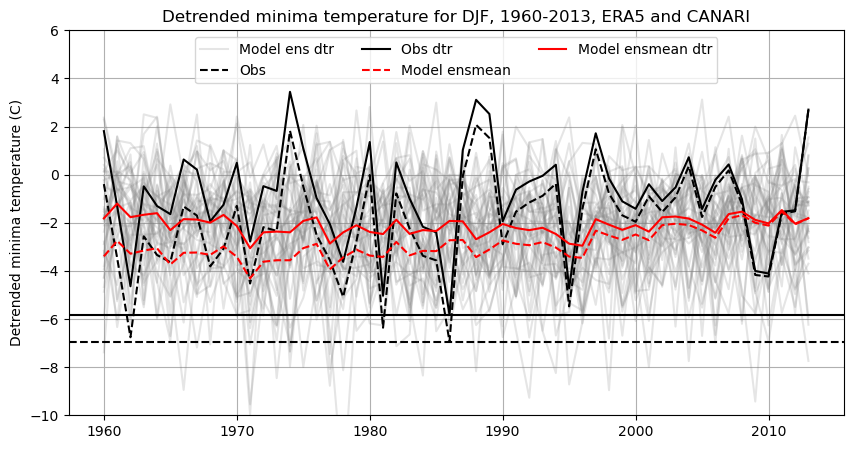

In [18]:
# ---------------------------------------------------------
# Now plot the detrended time series
# ---------------------------------------------------------

gev_funcs.plot_detrend_ts(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt,
    obs_var_name="data_c_min",
    model_var_name="tas_c_min",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    ylabel="Detrended minima temperature (C)",
    title="Detrended minima temperature for DJF, 1960-2013, ERA5 and CANARI",
    ylim=(-10, 6),
)

In [19]:
# ---------------------------------------------------------
# Calculate the mean bias in block minima temperatures
# ---------------------------------------------------------

block_minima_canari_dt_bc = gev_funcs.mean_bias_correct(
    model_df=block_minima_canari_dt,
    obs_df=block_minima_obs_dt,
    model_var_name="tas_c_min_dt",
    obs_var_name="data_c_min_dt",
)

Mean bias correction: -1.2655817370680058


In [20]:
%%time
# ---------------------------------------------------------
# Process the GEV params
# --------------------------------------------------------

# Process the GEV params - no bias correction
gev_params_raw = gev_funcs.process_gev_params(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt", # No bias correction
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    nboot=1000,
)

# Process the GEV params - with bias correction
gev_params_bc = gev_funcs.process_gev_params(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt_bc", # With bias correction
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    nboot=1000,
)

 14%|█▎        | 135/1000 [00:03<00:23, 36.29it/s]

100%|██████████| 1000/1000 [00:27<00:00, 36.77it/s]

CPU times: user 56.1 s, sys: 991 ms, total: 57.1 s
Wall time: 56.6 s


In [21]:
importlib.reload(gev_funcs)

<module 'gev_functions' from '/home/users/benhutch/unseen_multi_year/gev_functions.py'>

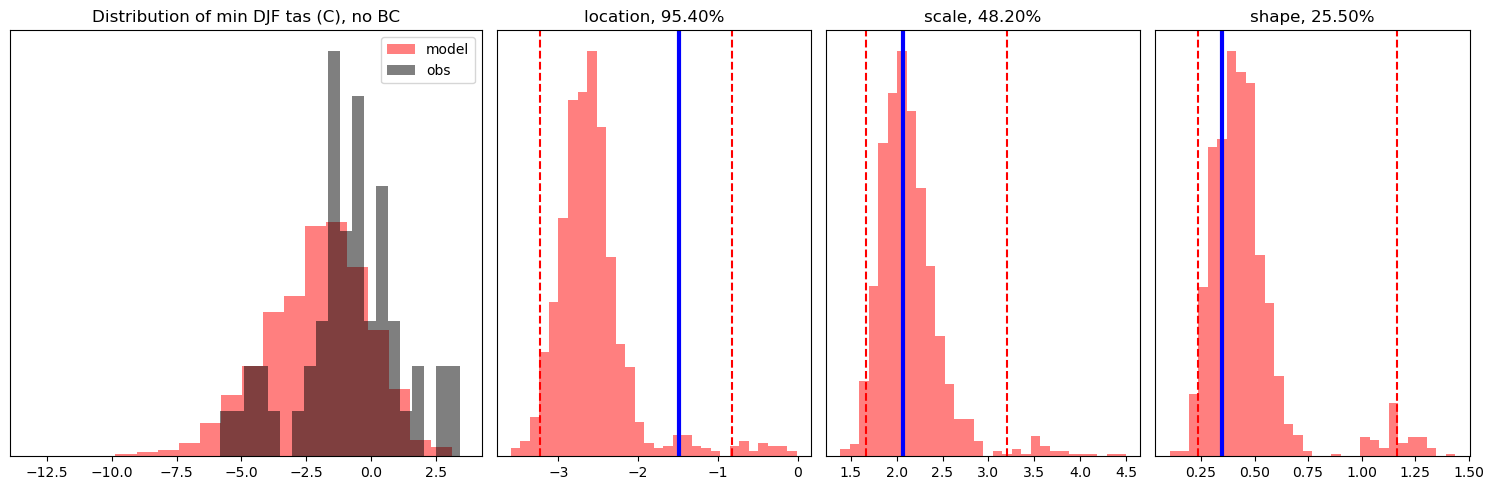

In [22]:
# ---------------------------------------------------------
# Now plot the GEV params
# ---------------------------------------------------------

# First plot the non mean bias corrected one
gev_funcs.plot_gev_params(
    gev_params=gev_params_raw,
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt",
    title="Distribution of min DJF tas (C), no BC",
    obs_label="obs",
    model_label="model",
    figsize=(15, 5),
)

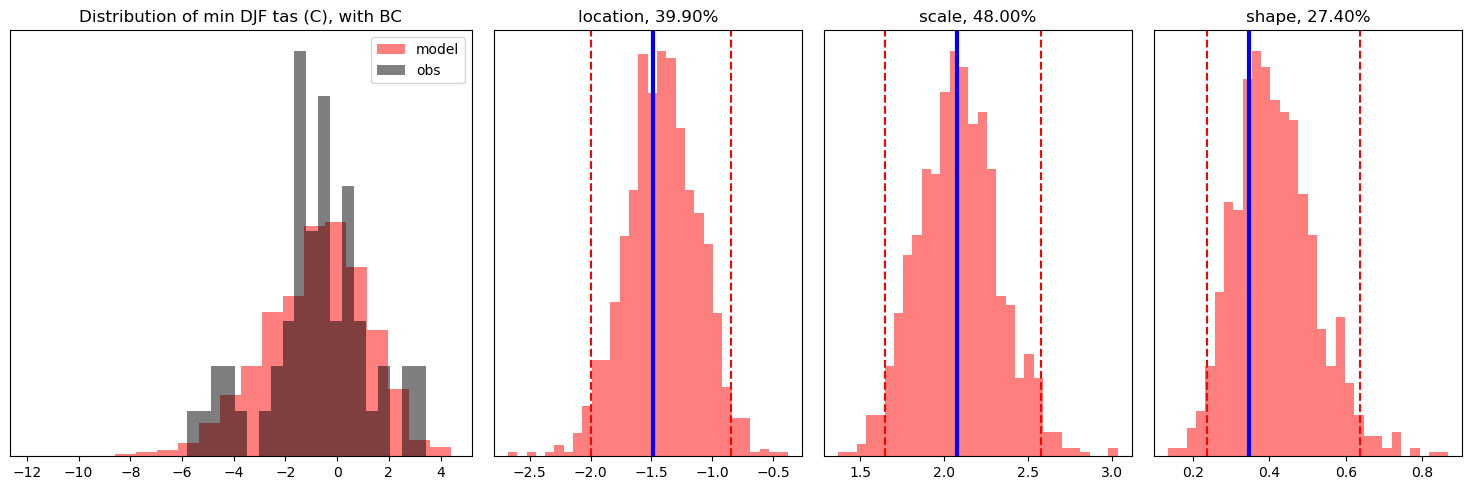

In [23]:
# ---------------------------------------------------------
# Now plot the GEV params for the mean bias corrected one
# ---------------------------------------------------------

gev_funcs.plot_gev_params(
    gev_params=gev_params_bc,
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_var_name="data_c_min_dt",
    model_var_name="tas_c_min_dt_bc",
    title="Distribution of min DJF tas (C), with BC",
    obs_label="obs",
    model_label="model",
    figsize=(15, 5),
)

In [24]:
# ---------------------------------------------------------
# Specifically import the dot plot function
# ---------------------------------------------------------

sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import dot_plot

In [25]:
# ---------------------------------------------------------
# Preprocess the time data for the dot plot
# ---------------------------------------------------------

# Set effective dec year as a datetime for the obs
block_minima_obs_dt["effective_dec_year"] = pd.to_datetime(
    block_minima_obs_dt["effective_dec_year"], format="%Y"
)

# Set effective dec year as a datetime for the model
block_minima_canari_dt_bc["effective_dec_year"] = pd.to_datetime(
    block_minima_canari_dt_bc["effective_dec_year"], format="%Y"
)

# Set this as the index for the obs
block_minima_obs_dt.set_index("effective_dec_year", inplace=True)

In [26]:
# ---------------------------------------------------------
# Find the coldest year in the obs
# ---------------------------------------------------------

min_value = block_minima_obs_dt["data_c_min_dt"].min()

# Locate the row at which this occurs
min_row = block_minima_obs_dt.loc[block_minima_obs_dt["data_c_min_dt"] == min_value]

# Print the entire row
print(min_row)

                    data_c_min  data_c_min_dt
effective_dec_year                           
1986-01-01           -6.941608      -5.819821


The worst event occurs in the year: 1974-01-01 00:00:00
The no. days for the worst event is: -5.819821167146117
Bad events have low values
The chance of a very bad event is: 1.25%
The chance of a very bad event is: 1 in 80 years
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/obs-data_c_min_dt_model-tas_c_min_dt_bc_quantile-0.2_solid-min_dot_plot_2025-03-10-13-53-20.pdf
Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/obs-data_c_min_dt_model-tas_c_min_dt_bc_quantile-0.2_solid-min_dot_plot_2025-03-10-13-53-20.pdf


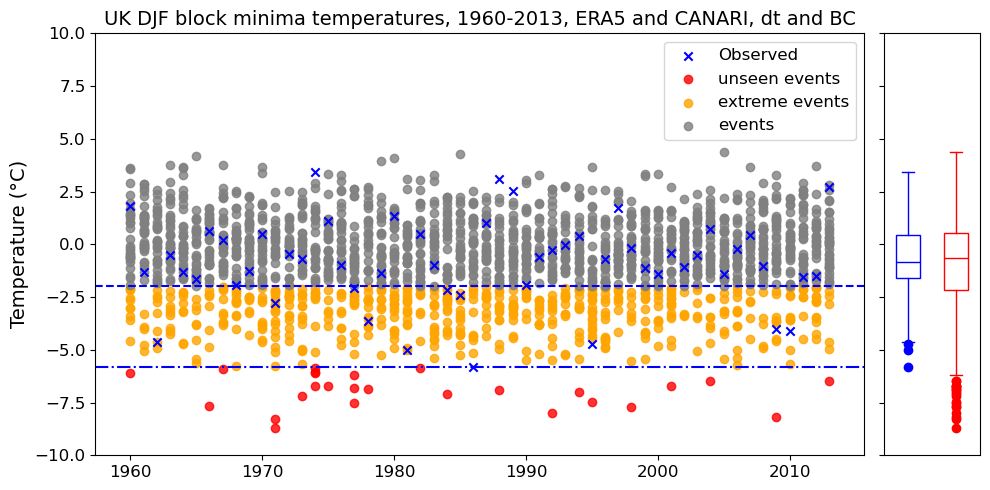

In [27]:
# ---------------------------------------------------------
# Now plot the dot plot for the bias corrected data
# ---------------------------------------------------------

dot_plot(
    obs_df=block_minima_obs_dt,
    model_df=block_minima_canari_dt_bc,
    obs_val_name="data_c_min_dt",
    model_val_name="tas_c_min_dt_bc",
    model_time_name="effective_dec_year",
    ylabel="Temperature (°C)",
    title="UK DJF block minima temperatures, 1960-2013, ERA5 and CANARI, dt and BC",
    ylims=(-10, 10),
    solid_line=np.min,
    dashed_quant=0.2,
)

### Wind speed ###

In [38]:
# ---------------------------------------------------------
# Load the model data
# ---------------------------------------------------------

# Set up the fname
# fname = "CANARI_sfcWind_UK_wind_box_1960-2014_day.csv"

# # Set up the directory in which the model data is stored
model_wind_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# Set up the empty dataframe
canari_wind = pd.DataFrame()

# Set up the canari_members
canari_members = np.arange(1, 41)

for year in tqdm(canari_years):
    for member in canari_members:
        # create the fpath
        fpath = os.path.join(model_wind_dir, f"canari-le-sfcWind-UK_wind_box-{year}-member-{member}-{canari_period}.csv")
        # check if the file exists
        if not os.path.exists(fpath):
            print(f"Missing file for {year}")
            # sys.exit()

        # Load the dataframe
        model_df_this = pd.read_csv(fpath)

        # concatenate the dataframes
        canari_wind = pd.concat([canari_wind, model_df_this], ignore_index=True)

100%|██████████| 65/65 [11:33<00:00, 10.67s/it]


In [41]:
canari_wind.head()

,member,time,sfcWind_u,sfcWind_v
0,1,1950-01-01 01:00:00,4.384397,0.028049
1,1,1950-01-01 02:00:00,4.602865,-0.102908
2,1,1950-01-01 03:00:00,4.807086,-0.239307
3,1,1950-01-01 04:00:00,4.942545,-0.354780
4,1,1950-01-01 05:00:00,4.986263,-0.414952


In [42]:
# ---------------------------------------------------------
# Now save the dataframe
# ---------------------------------------------------------

# Set up a fname for the canari wind data
fname = "canari_sfcWind_UK_wind_box_1960-2014.csv"

# set up the save directory
save_dir = "/home/users/benhutch/unseen_multi_year/dfs"

# Save the dataframe
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# set up the full path
fpath = os.path.join(save_dir, fname)

# if the fptha does not exist
if not os.path.exists(fpath):
    # save the dataframe
    canari_wind.to_csv(fpath, index=False)
else:
    print(f"File already exists: {fpath}")

    # load the dataframe
    canari_wind = pd.read_csv(fpath)

In [44]:
# ---------------------------------------------------------
# Process the canari data
# ---------------------------------------------------------

# create a new column for the wind speed
canari_wind["sfcWind"] = np.sqrt(canari_wind["sfcWind_u"] ** 2 + canari_wind["sfcWind_v"] ** 2)

# add a new column for the date
canari_wind["date"] =canari_wind["time"].apply(
    lambda x: x.split(" ")[0]
)

In [46]:
canari_wind.tail()

,member,time,sfcWind_u,sfcWind_v,sfcWind,date
22463995,40,2014-12-30 20:00:00,2.302501,-8.051042,8.373816,2014-12-30
22463996,40,2014-12-30 21:00:00,2.175797,-8.202165,8.485847,2014-12-30
22463997,40,2014-12-30 22:00:00,2.029546,-8.333979,8.577544,2014-12-30
22463998,40,2014-12-30 23:00:00,1.921143,-8.451058,8.666670,2014-12-30
22463999,40,2015-01-01 00:00:00,1.881207,-8.508838,8.714314,2015-01-01


In [47]:
# ---------------------------------------------------------
# Further processing to calculate daily means
# ---------------------------------------------------------

# make sure the member is formatted as a string
canari_wind["member"] = canari_wind["member"].apply(
    lambda x: str(x).zfill(2)
)

# Select only the numeric columns for aggregation
numeric_columns = canari_wind.select_dtypes(include='number').columns

# Aggregate the data to daily means for numeric columns, grouped by both date and member
df_canari_uk_daily = canari_wind.groupby(["date", "member"])[numeric_columns].mean().reset_index()

In [52]:
# ---------------------------------------------------------
# Further processing to get effective dec year
# ---------------------------------------------------------

# Rename the time column to date
df_canari_uk_daily.rename(columns={"date": "time"}, inplace=True)

df_canari_uk_daily["effective_dec_year"] = df_canari_uk_daily.apply(
    lambda row: gev_funcs.determine_effective_dec_year_canari(row), axis=1
)

In [61]:
df_canari_uk_daily["month"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [55]:
# create a month column
df_canari_uk_daily["month"] = df_canari_uk_daily["time"].apply(
    lambda x: int(x.split("-")[1])
)

In [62]:
# limit to DJF
df_canari_uk_daily_DJF = df_canari_uk_daily[
    df_canari_uk_daily["month"].isin([12, 1, 2])
]

In [65]:
df_canari_uk_daily_DJF["month"].unique()

array([ 1,  2, 12])

In [66]:
# ---------------------------------------------------------
# Load the observed data
# ---------------------------------------------------------

# Set up the path to the obs data
obs_wind_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_UK_wind_box_1960-2018_daily_2025-02-26.csv"

# load the obs data
df_obs_wind = pd.read_csv(obs_wind_path)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_wind["time"] = pd.to_datetime(df_obs_wind["time"], origin="1952-01-01", unit="D")

# subset the obs data to D, J, F
df_obs_wind = df_obs_wind[df_obs_wind["time"].dt.month.isin([12, 1, 2])]

# Add the efefctive dec year column
df_obs_wind["effective_dec_year"] = df_obs_wind.apply(
    lambda row: gev_funcs.determine_effective_dec_year(row), axis=1
)

In [67]:
# ---------------------------------------------------------
# Subset both to the same unique dec years
# ---------------------------------------------------------

# Set p the common years
common_years = np.arange(1960, 2013 + 1)

# subset the obs data
df_obs_wind_subset = df_obs_wind[
    df_obs_wind["effective_dec_year"].isin(common_years)
]

# subset the canari data
df_canari_uk_daily_DJF_subset = df_canari_uk_daily_DJF[
    df_canari_uk_daily_DJF["effective_dec_year"].isin(common_years)
]

In [70]:
df_obs_wind_subset.columns

Index(['time', 'data', 'effective_dec_year'], dtype='object')

In [71]:
df_canari_uk_daily_DJF_subset.columns

Index(['time', 'member', 'sfcWind_u', 'sfcWind_v', 'sfcWind',
       'effective_dec_year', 'month'],
      dtype='object')

In [72]:
# ---------------------------------------------------------
# Now quantify the block minima for the winters
# ---------------------------------------------------------

# Process the observations from ERA5
block_minima_obs = gev_funcs.obs_block_min_max(
    df=df_obs_wind_subset,
    time_name="effective_dec_year",
    min_max_var_name="data",
    new_df_cols=[],  # no new cols
    process_min=True,
)

# Process the model data from CANARI
block_minima_canari = gev_funcs.model_block_min_max(
    df=df_canari_uk_daily_DJF_subset,
    time_name="effective_dec_year",
    min_max_var_name="sfcWind",
    new_df_cols=[],  # no new cols
    process_min=True,
)

In [73]:
block_minima_canari.columns

Index(['effective_dec_year', 'member', 'sfcWind_min'], dtype='object')

In [74]:
block_minima_obs.columns

Index(['effective_dec_year', 'data_min'], dtype='object')

In [75]:
# ---------------------------------------------------------
# Calculate the mean bias in block minima wind speeds
# ---------------------------------------------------------

block_minima_canari_wind_bc = gev_funcs.mean_bias_correct(
    model_df=block_minima_canari,
    obs_df=block_minima_obs,
    model_var_name="sfcWind_min",
    obs_var_name="data_min",
)

Mean bias correction: -2.250934473155456


In [76]:
%%time
# ---------------------------------------------------------
# Process the GEV params
# --------------------------------------------------------

# Process the GEV params - no bias correction
gev_params_raw = gev_funcs.process_gev_params(
    obs_df=block_minima_obs,
    model_df=block_minima_canari_wind_bc,
    obs_var_name="data_min",
    model_var_name="sfcWind_min", # No bias correction
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    nboot=1000,
)

# Process the GEV params - with bias correction
gev_params_bc = gev_funcs.process_gev_params(
    obs_df=block_minima_obs,
    model_df=block_minima_canari_wind_bc,
    obs_var_name="data_min",
    model_var_name="sfcWind_min_bc", # With bias correction
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    nboot=1000,
)

100%|██████████| 1000/1000 [00:27<00:00, 36.30it/s]

CPU times: user 54.5 s, sys: 289 ms, total: 54.8 s
Wall time: 54.8 s


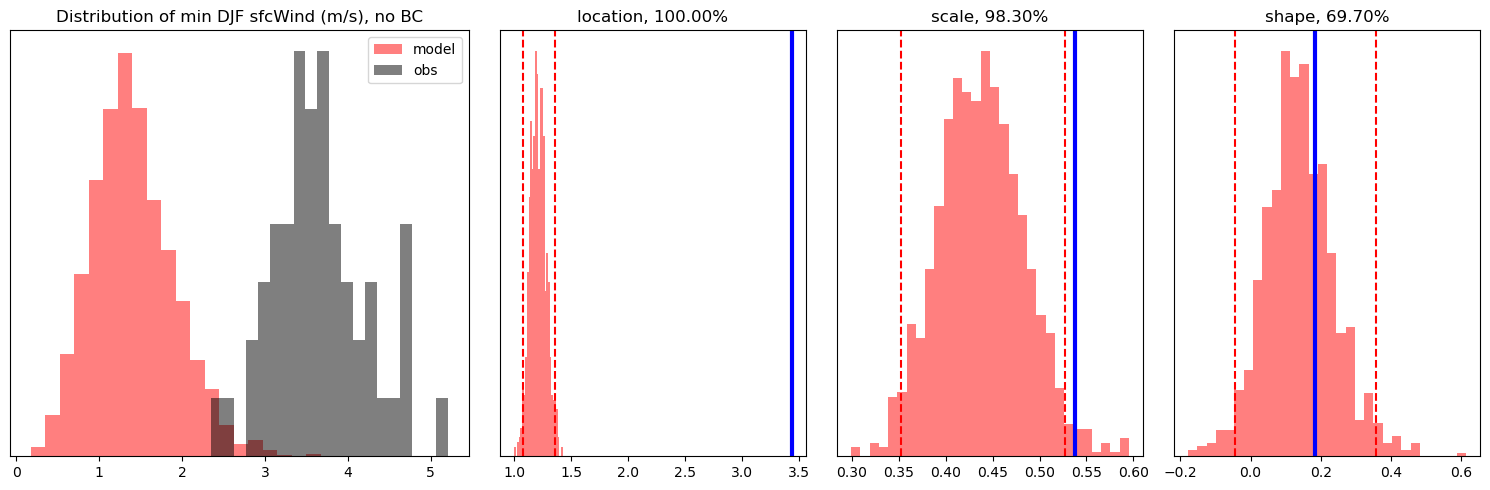

In [77]:
# ---------------------------------------------------------
# Now plot the GEV params
# ---------------------------------------------------------

# First plot the non mean bias corrected one
gev_funcs.plot_gev_params(
    gev_params=gev_params_raw,
    obs_df=block_minima_obs,
    model_df=block_minima_canari_wind_bc,
    obs_var_name="data_min",
    model_var_name="sfcWind_min",
    title="Distribution of min DJF sfcWind (m/s), no BC",
    obs_label="obs",
    model_label="model",
    figsize=(15, 5),
)

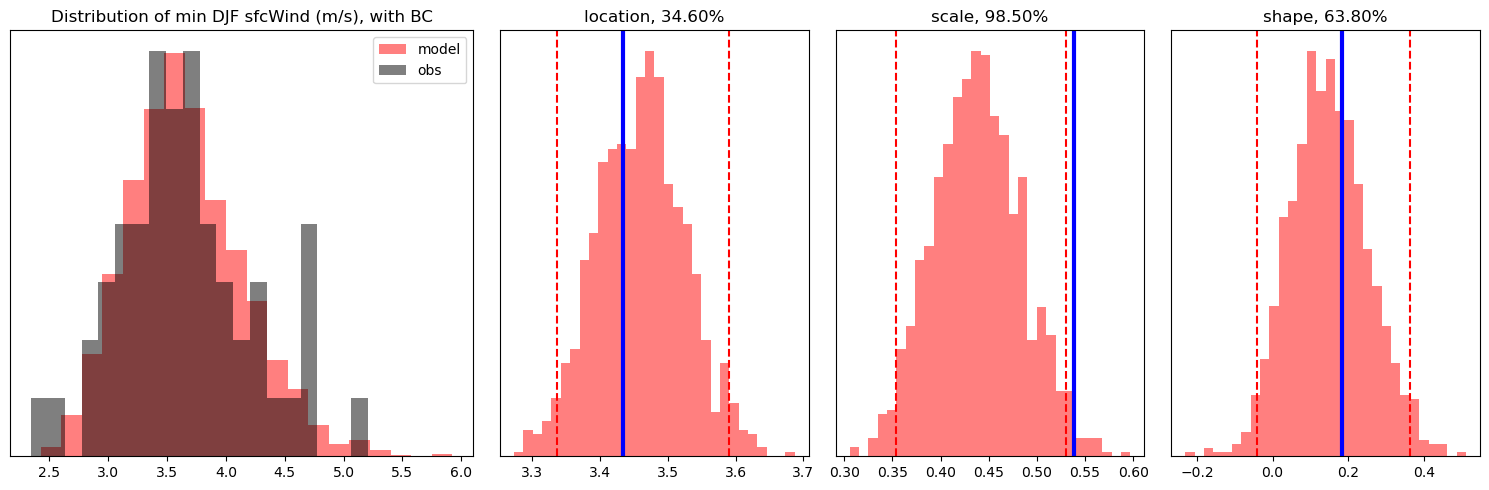

In [78]:
# Now plot the GEV params for the mean bias corrected one
gev_funcs.plot_gev_params(
    gev_params=gev_params_bc,
    obs_df=block_minima_obs,
    model_df=block_minima_canari_wind_bc,
    obs_var_name="data_min",
    model_var_name="sfcWind_min_bc",
    title="Distribution of min DJF sfcWind (m/s), with BC",
    obs_label="obs",
    model_label="model",
    figsize=(15, 5),
)